In [1]:
import pandas as pd                                  # smart dataFrame for data manipulations
import numpy as np
import sys
import scipy

import requests                                      # used to read data from URL address
from requests.auth import HTTPBasicAuth              # setup authentication of URL 

import matplotlib.pyplot as plt                      # plotting results in a neat way!
from matplotlib.colors import ListedColormap         # ..used for decision surface plots
import matplotlib as mpl

import seaborn as sn                                 # nice for plotting heatmaps, used for correlation matrix

from sklearn import tree                             # classifier decision trees
from sklearn import neighbors                        # classifier kNN
from sklearn.ensemble import RandomForestClassifier  # classifier Random Forest
from sklearn.neural_network import MLPClassifier     # classifier multi-layer perceptron
from random import uniform as random_uniform         # random number generator for randomizing train/test samples

from IPython.core.display import Image               # ...for displaying images in notebook, used for decision tree pictures
from six import StringIO                             # write string buffers as files, used for making decision tree pictures
import re
import io
import VisualizeNN as VisNN

mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

In [2]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX" # Make sure the url is the raw version of the file on GitHub
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46" # Make sure the url is the raw version of the file on GitHub
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [3]:
# Making the training data sets

GamTrain = GamRaw.sample(frac=0.1)
NeutTrain = NeutRaw.sample(frac=0.1)

# Add a distriction column to the data, to know which is gam and which is neut for later graphing

GamTrain["distinction"] = 1
NeutTrain["distinction"] = 0

In [4]:
# Combining Neut and Gam dataframes for a single frame for plotting

plotFrame = pd.concat([GamTrain, NeutTrain], ignore_index=True, axis=0)

print(plotFrame.shape)
plotFrame.head(-1)

(8687, 12)


Th        Ph         E  NrHits  NrBumps        E1      E1E9  \
0      67.95980  112.9980  3.148580      19        1  2.397440  0.789567   
1      79.93110 -170.9350  2.078770      19        1  0.883612  0.447160   
2      51.76150  165.1030  2.940310      22        1  2.310500  0.830061   
3       2.15273  -44.0488  4.662710      23        3  2.844350  0.692358   
4      67.39370  169.6200  4.953170      31        1  3.323750  0.706553   
...         ...       ...       ...     ...      ...       ...       ...   
8681  108.82200  -67.4233  1.005460      27        1  0.288496  0.390323   
8682   48.54000 -126.2540  0.929174      23        1  0.373234  0.644000   
8683   53.37390  116.2060  0.171254       3        1  0.118477  0.738379   
8684   14.00410  -70.0345  1.474860      27        2  0.418051  0.352510   
8685   84.83040 -127.0750  0.337180       4        1  0.270961  0.842969   

         E9E25       Z20       Z53    LatMom  distinction  
0     0.974702  0.976197  0.001623  0.886897            1  
1     0.958529  0.969505  0.002177  0.314575            1  
2     0.953765  0.977157  0.002567  0.318099            1  
3     0.914525  0.862060  0.014871  0.785748            1  
4     0.959539  0.968132  0.000725  0.805908            1  
...        ...       ...       ...       ...          ...  
8681  0.833476  0.807776  0.032026  0.982710            0  
8682  0.874365  0.508250  0.169396  0.995957            0  
8683  1.000000  0.940470  0.029903  0.481242            0  
8684  0.898802  0.866792  0.014114  0.867654            0  
8685  1.000000  0.932869  0.006824  0.951471            0  

[8686 rows x 12 columns]

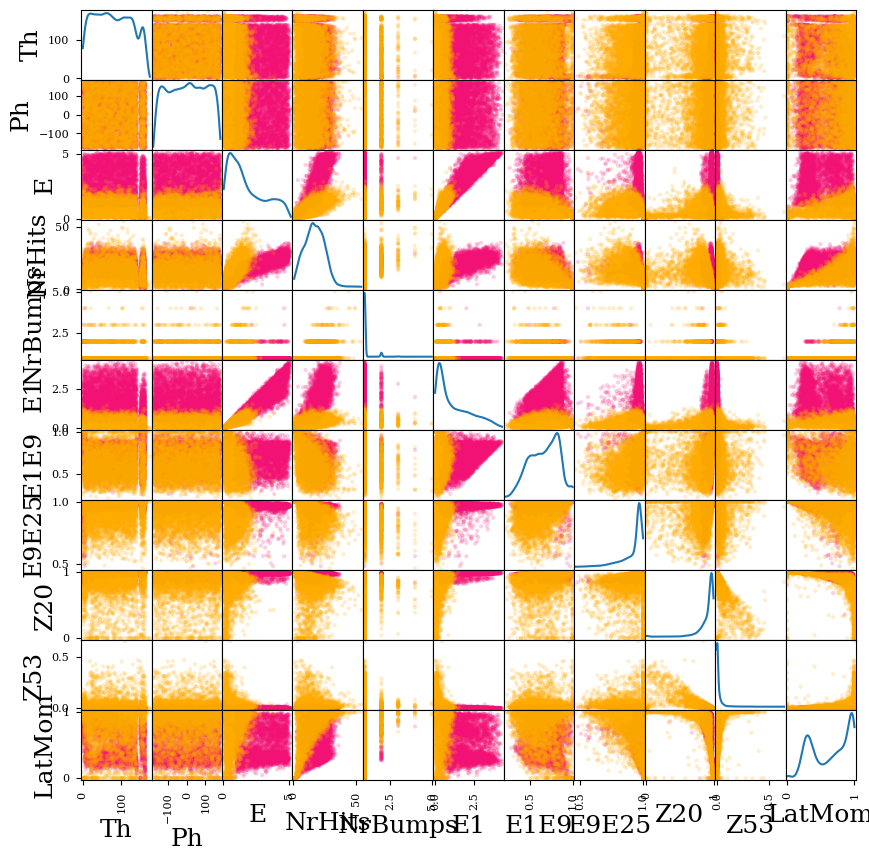

In [5]:
colors = ['#f21175', '#ffab00']

_ = pd.plotting.scatter_matrix(plotFrame[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']], 
                               figsize=(10,10), 
                               diagonal='kde', 
                               alpha=0.2, 
                               color=[colors[x-1] for x in list(plotFrame.distinction)])

In [6]:
# If you don't have seaborn then run the line below
# !pip install seaborn

In [7]:
import seaborn as sns
from sklearn import cluster

def getClusters(k, frame, variables):
    '''
    Plots two parameters from a dataframe with cluster centers.
    
    Parameters:
    k (int)                  -- Number of clusters
    frame (pandas dataframe) -- The dataframe to examine
    variables (numpy array)  -- Columns to examine
    '''
    
    start = np.random.rand(k, 2)
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000, init=start, n_init=1)
    kmeans.fit(frame[variables])
    
    labels    = kmeans.labels_
    centroids = kmeans.cluster_centers_
    nriter    = kmeans.n_iter_
    
    centroids = centroids.reshape(k, 2)
    centroidFrame = pd.DataFrame(centroids, columns =['x', 'y'])
    
    fig, axes = plt.subplots(nrows=1, ncols=1,
                            figsize=(8, 8),
                            layout="constrained"
                            )

    sns.scatterplot(data=frame, x=variables[0], y=variables[1], marker='.', hue='distinction', ax=axes).set_title(f'{variables[0]} v.s. {variables[1]}')
    sns.scatterplot(data=centroidFrame, x='x', y='y', marker='X', color='black', s=200, ax=axes)
    plt.show()


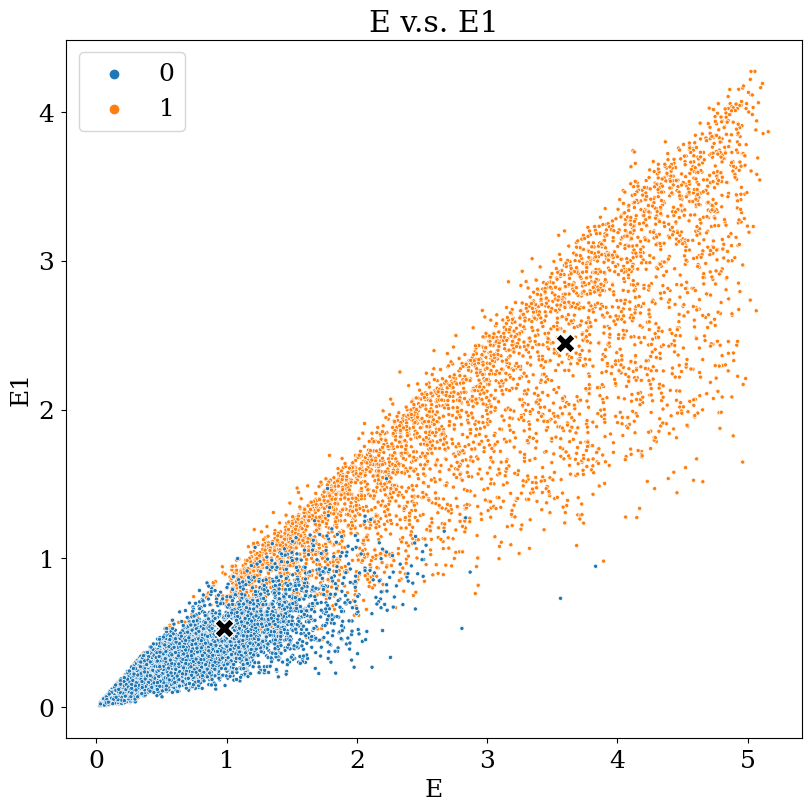

In [8]:
getClusters(2, plotFrame, ['E', 'E1'])

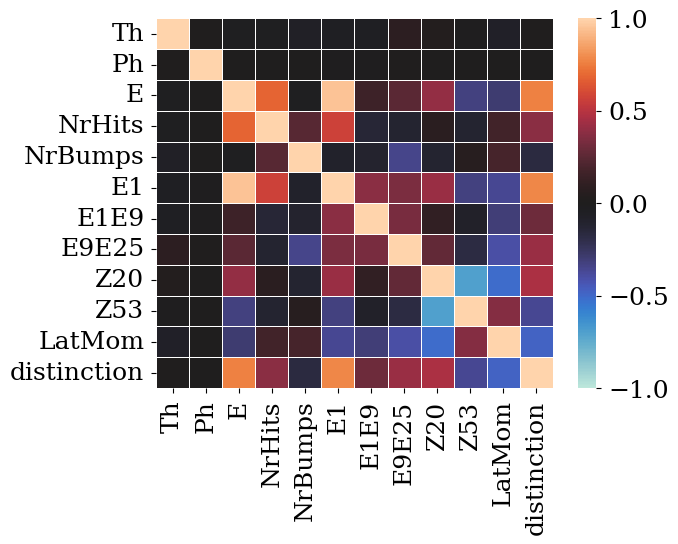

<Figure size 50000x50000 with 0 Axes>

In [9]:
# Heatmap for data correlations

sns.heatmap(plotFrame.corr(), 
            annot=False,
            linewidths=0.5,
            vmin=-1,
            vmax=1,
            center=0,
            cbar=True)

plt.figure(figsize=(500, 500))
plt.show()

#plotFrame.head()

In [10]:
## data normalisation function

def NormalizeData(data, feature_list):
    """
    Normalize features in "feature_list" of dataFrame "data".
    New features will be added as columns to the dataFrame with label "_normal".
    The function returns the updated table.
    """
    
    # Dont modify the original dataFrame "data"
    data_tmp = data.copy()

    # Run over all features and create new column with "_normal"
    for feature in feature_list:
        feature_new = feature + "_normal"
        data_tmp[feature_new] = (data_tmp[feature] - data_tmp[feature].mean()) / data_tmp[feature].std()

    # Return the updated dataFrame
    return data_tmp


In [11]:
# we now normalise the features that could be correleated later

plotFrame = NormalizeData(plotFrame, ["E", "NrHits", "E1", "E1E9"])

# plotFrame.head()
plotFrame[["E_normal", "NrHits_normal", "E1_normal", "E1E9_normal"]].describe()

E_normal  NrHits_normal     E1_normal   E1E9_normal
count  8687.000000   8.687000e+03  8.687000e+03  8.687000e+03
mean      0.000000   1.472288e-16  3.010012e-16 -6.543504e-17
std       1.000000   1.000000e+00  1.000000e+00  1.000000e+00
min      -1.290865  -2.103799e+00 -1.102584e+00 -2.762227e+00
25%      -0.831062  -7.833672e-01 -8.174301e-01 -8.115920e-01
50%      -0.306180   8.892054e-03 -3.860566e-01  9.593054e-02
75%       0.742000   6.691081e-01  6.857824e-01  8.196431e-01
max       2.373003   4.894491e+00  2.991092e+00  2.006272e+00

In [12]:
#
# The engine code behind the ML algorithm used in this example.
# We make use of classifier "classifier":
#

def Classify(classifier, data, params,
             prop_test=0.5, feature_list=['E_normal','NrHits_normal'], 
             plot_ds=False, plot_tree=False, plot_network=False):
    """
    Use "classifier" algorithm to classify dataset data. Use feature list feature_list
    and use prop_test fraction of the data as test sample, rest for training.
    The function returns an updated dataset including a column with predicted class.
    """
    
    assert 0<prop_test<1
     
    #
    # make a copy of the dataframe. The original table will not be altered.
    #
    data_tmp = data.copy()
    #
    # Add a column specifying whether event is used for training or for testing
    #
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)
    #
    # Extract two seperate datasets for training (train) and testing (test)
    #
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    
    if   (classifier=="DT"):
        # we create an instance of Decision Tree Classifier.
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          min_impurity_decrease=params[0],
                                          max_depth=params[1])
    elif (classifier=="RF"):
        # we create an instance of Random Forest Classifier.
        clf = RandomForestClassifier(n_estimators=params[0], 
                                     max_features=params[1])
    elif (classifier=="kNN"):
        # we create an instance of kNN Classifier.
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    elif (classifier=="MLP"):
        # we create an instance of MLP Classifier.
        clf = MLPClassifier(solver='lbfgs', activation='logistic', #solver=quasi-Newton, activation=sigmoid
                            max_iter=5000, 
                            hidden_layer_sizes=params[0])
    else:
        print(" Classifier not implemented: ", classifier)
        return None
    
    # Fit the data with the selected classifier...
    clf.fit(train[feature_list],train['distinction'])
    
    #evaluate the training points
    trainpred = clf.predict(train[feature_list]) # majority vote result
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])   # majority vote result
    test['prediction'] = [x for x in testpred]
 
    data_update = train.append(test)
     
    # Make it possible to plot the decision surface if plot_ds flag set to True and nr of features equals 2.
    if (plot_ds) & (len(feature_list)==2):
        PlotDecisionSurface(clf,data_update,feature_list)

    # In the case the classifier is a decision tree, allow for the possibility to plot the tree, 
    # only when plot_tree is set to True.
    if (plot_tree) & (classifier=="DT"): 
        PlotTree(clf, feature_list)
  
    # Plot the network structure in case of multi-layer perceptron
    # Only when plot_network flag is set to True. Comment out if VisNN code not available!
    if (plot_network) & (classifier=="MLP"):   
        network_structure = np.hstack(([len(feature_list)], np.asarray(clf.hidden_layer_sizes), [data['distinction'].nunique()]))
        # Draw the Neural Network with weights given by clf.coefs_
        network=VisNN.DrawNN(network_structure, clf.coefs_)
        network.draw()
            
    # Return the updated version of the dataFrame including labels "is_train" and "predicted".
    return data_update


In [13]:
kNNTest = Classify(classifier='kNN', 
                   data=plotFrame,params=[3], 
                   feature_list=['E_normal','NrHits_normal'])


C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = [x for x in trainpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = [x for x in testpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [14]:
#
# GetNrOfSuccesses(dataFrame): returns fraction of succesfull classifications for training and test 
#                              part of the data table and used as the metric for the fruit analysis!
#

def GetNrOfSuccesses(data):
    """
    Reads as input DataFrame "data" and return the fraction of successfull classifications of
    the training and test part of the table. This function only works with an updated DataFrame
    that includes the columns "is_train" and "prediction", generated by Classify() function.
    """
    
    nrtrain_instances = len(data[(data.is_train == True)])
    nrtest_instances  = len(data[(data.is_train == False)])
    
    nrtrain_success = len(data[(data.is_train == True)  & (data.prediction == data.distinction)])
    nrtest_success  = len(data[(data.is_train == False) & (data.prediction == data.distinction)])
    
    return (nrtrain_success/nrtrain_instances), (nrtest_success/nrtest_instances)

In [15]:
#
# PlotTree: a procedure that displays the tree structure of classifier clf...
#

def PlotTree(clf, feature_list):
    """
    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return  

In [16]:
from matplotlib.colors import ListedColormap

#
# PlotDecisionSurface: function that creates decision surface based on classifier clf
# and features in feature_list of dataFrame data. It uses "meshgrid" of numpy to generate
# grid of points to evaluate by classifier. For plotting, it uses "pcolormesh" of matplotlib.
#

def PlotDecisionSurface(clf, data, feature_list, label='distinction', step=0.01):
    """
    Function that creates a decision surface of classifier "clf"
    together with features from the two entries of the "features_list" of "data"
    """
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the three classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#ffde9e', '#b8ea9d'])
    cmap_bold  = ListedColormap(['#ff8c28', '#11bb11'])
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data[label], cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return


C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = [x for x in trainpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = [x for x in testpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

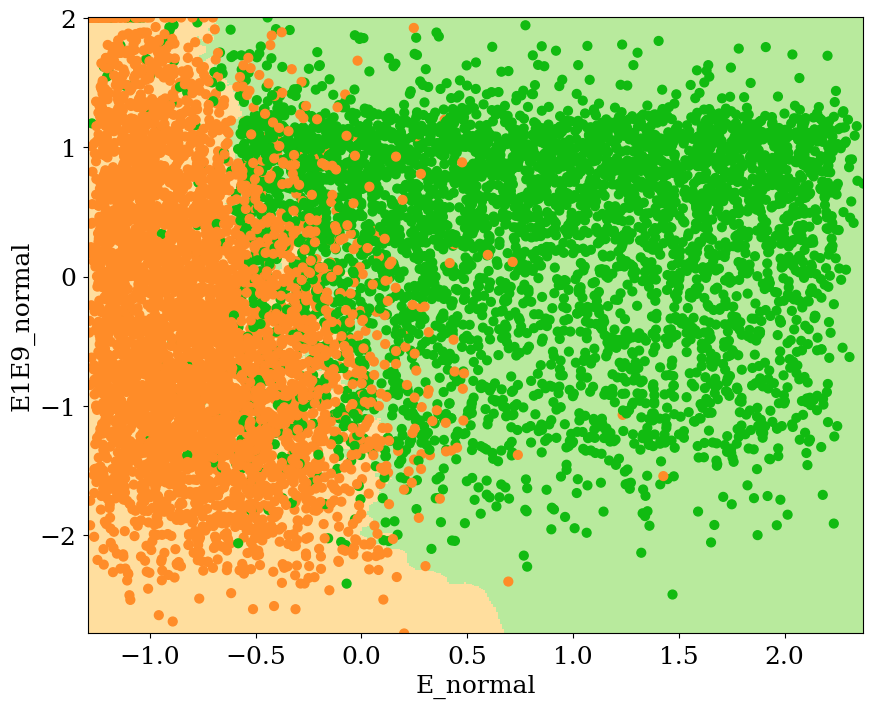

In [17]:
#
# Let's test Classify function for a kNN test, and see what it creates ;-)
#
classifier            = 'kNN'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1E9_normal'] #Q: do you really have to use _normal features?
plot_ds               = True
plot_tree             = True
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=[9], prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)

C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prediction'] = [x for x in trainpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = [x for x in testpred]
C:\Users\User\AppData\Local\Temp\ipykernel_17036\1259104443.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

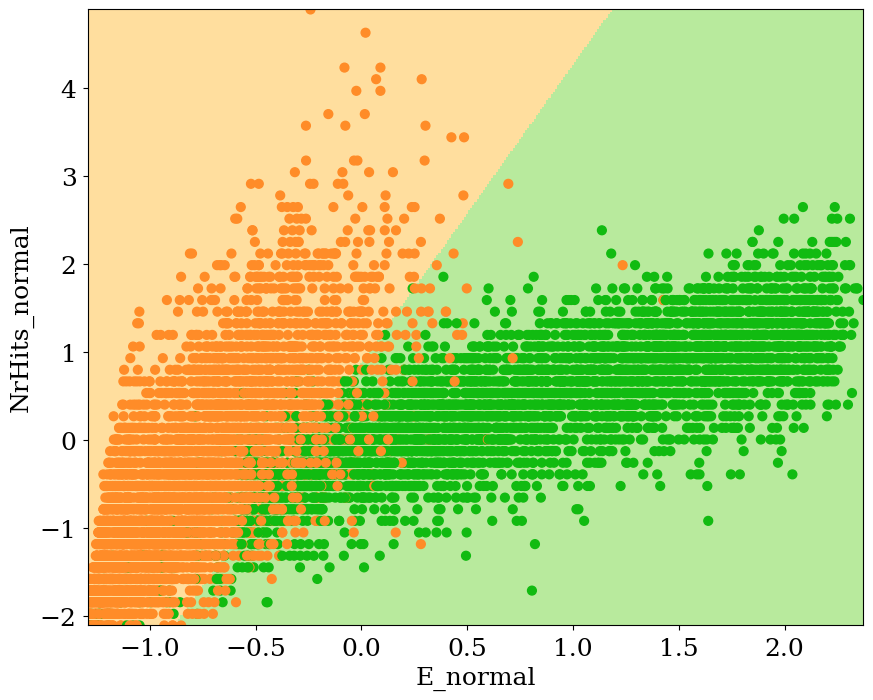

FOM =  63.2609948384812


In [40]:
#
# Let's test Classify function for a multi-layer perceptron, and see what it creates ;-)
#
classifier            = 'MLP'
hidden_layers         = (1)
params                = [hidden_layers]
prop_test             = 0.3
feature_list          = ['E_normal', "NrHits_normal"]
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

print('FOM = ', FOM(data_new))

In [58]:
def FOM(data):
    """
    A function which takes data_new as its input and outputs
    the FOM for that given set of data
    """
    #Droping all features except for 'distinction' and 'prediction'
    data_FOM = data.loc[data['is_train'] == False]  #diselecting the training data
    data_FOM = data.drop(columns=['Th', 'Ph','NrHits','NrBumps','E','E1','E1E9','E9E25','Z20','Z53','LatMom','E_normal','NrHits_normal','E1_normal','E1_normal','E1E9_normal'])

    #Selecting the rows where 'prediction'=1 ie Gam and measring length  
    S = len(data_FOM.loc[data_FOM['prediction'] == 1])

    #Selecting the rows for when 'prediction' =! 'distinction' and measuring length
    B = len(data_FOM.loc[(data_FOM['distinction'] == 0) & (data_FOM['prediction'] == 1)])

    #Compute FOM
    FOM = S / np.sqrt(S + B)
    
    return FOM